In [1]:
using PyPlot
using Random
using Distributions

In [2]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimize.jl");
include("../src/plotting.jl");

In [3]:
t = Array(2020:1.:2200);

GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t)
)

Economics(0.2222222222222222, 0.025, 1.0, 2.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [5]:
Random.seed!(1)
d = Normal(0.65, 0.13)
feedback_samples = rand(d, 100)
feedback_samples[feedback_samples .>= 0.999] .= NaN
feedback_samples[feedback_samples .<= 0.] .= NaN

ECS₀ = 1.2
ECS_samples = ECS₀ ./ (1. .-feedback_samples);

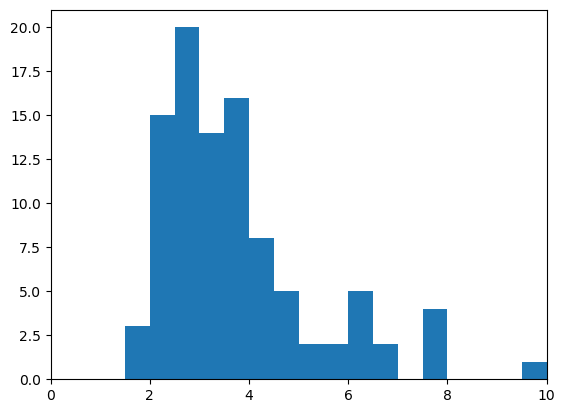

(0, 10)

In [6]:
hist(ECS_samples, bins=0.:0.5:20.)
xlim([0,10])

Converged after 474 iterations. Converged after 461 iterations. Converged after 572 iterations. Converged after 520 iterations. Converged after 583 iterations. Converged after 472 iterations. Converged after 487 iterations. Converged after 612 iterations. Converged after 436 iterations. Converged after 453 iterations. Converged after 427 iterations. Converged after 377 iterations. Converged after 448 iterations. Converged after 567 iterations. Converged after 456 iterations. Converged after 525 iterations. Converged after 576 iterations. Converged after 606 iterations. Converged after 502 iterations. Converged after 579 iterations. Converged after 605 iterations. Converged after 395 iterations. Converged after 414 iterations. Converged after 433 iterations. Converged after 526 iterations. Converged after 368 iterations. Converged after 527 iterations. Converged after 579 iterations. Converged after 595 iterations. Converged after 525 iterations. Converged after 538 iterations. Converge

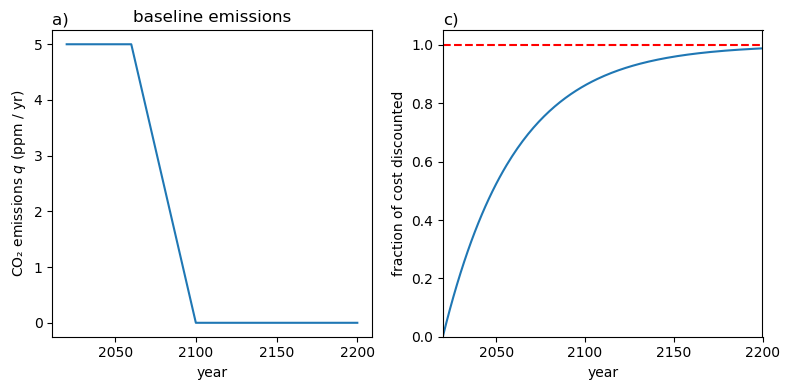

In [7]:
ensemble = Dict{String, ClimateModel}();
first = true
for member_id in 1:length(ECS_samples)
    present_year = 2020.
    ECS = ECS_samples[member_id]
    name = "member $member_id";
    controls = init_linear_controls(t);
    model = ClimateModel(name, ECS, t, controls, economics, present_year);
    optimize!(model)
    
    if CO₂(model)[end-1] < 1.e5
        ensemble[name] = model
    end
        
    if first; plot_setup(model); first=false; end
end

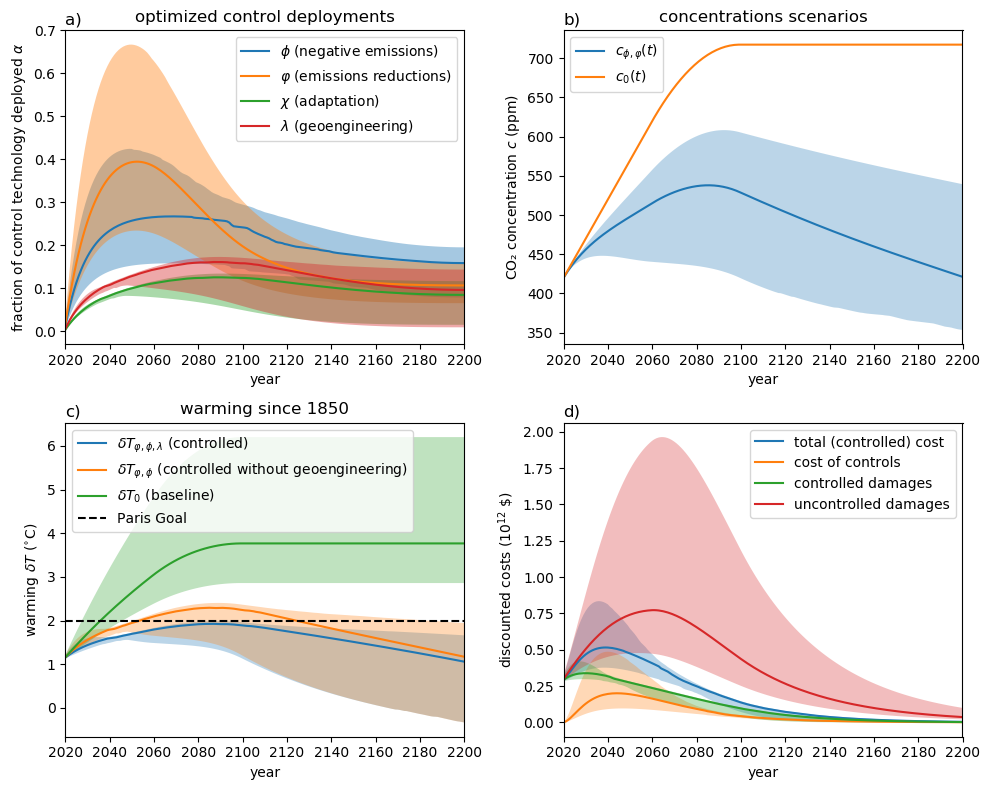

In [8]:
plot_ensemble_stats(ensemble, t)